In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [2]:
#Load cleaned data
df = pd.read_csv('../data/processed/cleaned_hospital_los.csv')

In [3]:
# BUILD X (FEATURES) AND Y (TARGET)
# Target variable
y = df['lengthofstay']

# Features (drop target and ID)
X = df.drop(columns=['lengthofstay', 'eid'])

X.shape, y.shape


((100000, 29), (100000,))

In [4]:
# TRAIN/TEST SPLIT
# We already imported train_test_split before
X_train, X_test, y_train, y_test = train_test_split(
    X,y,  #the function keeps x and y synchronized so row in 37x matches row in 37y after splitting
    test_size=0.2,  
    random_state=42 #for reproducibility
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((80000, 29), (20000, 29), (80000,), (20000,))

In [5]:
# BASELINE TEST
# Compute mean LOS from the training set
baseline_pred_value = y_train.mean()

# Create predictions for all test patients
y_pred_baseline = np.full_like(y_test, fill_value=baseline_pred_value, dtype=float)

# Evaluate baseline performance
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_rmse = baseline_mse ** 0.5       # convert MSE → RMSE
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)

baseline_pred_value, baseline_rmse, baseline_mae



(np.float64(4.0017625), 2.342479413763598, 1.90031718375)

In [6]:
# BUILD THE RANDOM FOREST MODEL

# Step 1: Creating the model object without traiing
rf = RandomForestRegressor(
    n_estimators=100, #build 100 trees in the forest
    random_state=42, #repdroducibility, train the exact same model
    n_jobs=-1 #parallelization, -1 use all available CPU cores
)

#step 2: Training the model
rf.fit(X_train, y_train)

# Step 3: Making predictions
y_pred_rf = rf.predict(X_test)

# Evaluation of the model
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = rf_mse ** 0.5
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mse, rf_rmse, rf_mae, rf_r2

(1.9646049249999997, 1.4016436512180974, 0.8107995, 0.6419656259104661)

In [7]:
# COMPUTING FEATURE IMPORTANCES
# Creation of DataFrame of feature importnaces
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
})

#Sort descending
importances = importances.sort_values('importance', ascending=False)

importances.head(10)


,feature,importance
0,rcount,0.310779
26,fac_E,0.111890
13,hematocrit,0.061365
16,glucose,0.058134
19,bmi,0.057335
15,sodium,0.056580
18,creatinine,0.056569
20,pulse,0.044026
21,respiration,0.037792
14,neutrophils,0.035675


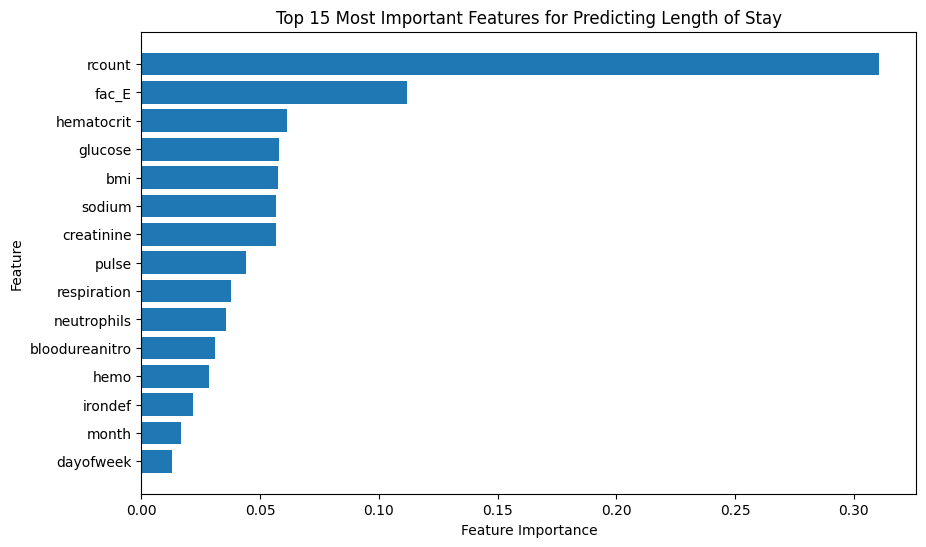

In [8]:
# Plotting feature importances in bar chart

import matplotlib.pyplot as plt

# Select the top 15 features
top_n = 15
top_features = importances.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Most Important Features for Predicting Length of Stay")
plt.gca().invert_yaxis()  # highest at the top
plt.show()

# Results and Model Interpretation**

## 1. ***Baseline Model Performance***

To understand whether machine learning adds value beyond simple heuristics, a baseline model was constructed by predicting the mean Length of Stay (LOS) from the training data for every patient in the test set.

Metric	Value
Baseline RMSE	2.34 days
Baseline MAE	1.90 days

This represents a naive strategy (“every patient stays 4 days”) and serves as a reference point for assessing model improvements.

## 2. ***Random Forest Model Performance***

A Random Forest Regressor was trained using clinical, demographic, laboratory, and operational features. Model performance on the test set was:

Metric	Value
Random Forest RMSE	1.40 days
Random Forest MAE	0.81 days
R² Score	0.64

The Random Forest model:
- Improves RMSE by ~40% compared to the baseline

- Reduces average prediction error (MAE) by more than 1 day

- Explains 64% of the variability in LOS across patients

This indicates that the model captures meaningful clinical and operational patterns influencing hospital stay duration.


## 3. ***Feature Importance Analysis***

Random Forest feature importances were examined to understand which variables contribute most to LOS prediction.

The top predictors were:

- rcount (previous hospital visits)

- fac_E (facility identifier)

- hematocrit

- glucose

- bmi

- sodium

- creatinine

- pulse

- respiration

- neutrophils


## ***Clinical and Operational Interpretation***

Patient utilization history (rcount) is the strongest predictor, suggesting that frequent hospital users often present with chronic or unstable conditions requiring extended care.

Facility effects (fac_E) highlight operational differences between hospitals or units. Some institutions systematically discharge earlier or later due to workflow, staffing, or case mix differences.

Laboratory markers (hematocrit, glucose, sodium, creatinine) reflect underlying physiological stress. Patients with abnormal lab values often require more diagnostics and monitoring, increasing LOS.

Vital signs (pulse, respiration) indicate patient acuity and are consistent predictors of hospitalization duration.

These patterns are consistent with clinical expectations and demonstrate that the model is learning medically plausible relationships.


## ***Conclusion***

The Random Forest model significantly outperforms the baseline and provides interpretable insights into the drivers of hospital LOS. By identifying the clinical and operational variables most associated with prolonged stays, this analysis can support:

capacity planning

patient flow optimization

risk stratification

targeted resource allocation

This establishes a strong foundation for further development, including hyperparameter tuning, model explainability techniques (e.g., SHAP), or integration into operational dashboards.


# **HYPERPARAMETER TUNNING**

We have to import the tool RandomizedSearchCV from scikit-learn in order to run the hyperparameter search.
This will take the base model RandomForestRegressor, try different hyperparameter combinations, evaluate them with cross-validation and five the best combination.

***step 2***

Then we have to create the rf_base, which can be thought of as an empty template model that the tuner will configure. 

***step 3***

Once we have the rf_base created, we need to define the hyperparameter search space by making the param_distributions object (a dictionary).
The main parameters will be:

- ***'n_estimators'***: how many trees in the forest. More trees → more stable but slower We let it choose between 100, 200, 300

- ***'max_depth'***: how deep each tree can grow. None → no limit (trees can grow deep = risk of overfitting) 5, 10, 20 → more shallow, simpler trees

- ***'min_samples_split'***: minimum number of samples required to split a node. 2 → very flexible. 5 or 10 → prevents splitting on tiny groups

- ***'min_samples_leaf'***: minimum number of samples in a leaf. 1 → can create very small leaves. 2, 4 → smoother predictions, less overfitting

- ***'max_features'***: how many features to consider at each split. 'auto' → (for regressors, usually same as n_features). 'sqrt' → sqrt(number of features), a classic RF setting. 0.5 → 50% of features chosen randomly per split

So RandomizedSearchCV will randomly pick combinations like:

- n_estimators = 200, max_depth = 10, min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt' …and so on, for n_iter different combinations.

***Step 4*** 
We now create the RandomizedSearchCV object: Base model + search space + CV configurtion.

***Step 5***
Run the search. In this case if we set n_iter=20 in step 4,  For each of the 20 iterations it will:

- Randomly choose a set of hyperparameters from param_distributions

- Train a Random Forest using those hyperparameters on training folds

- Evaluate using validation fold (MSE)

- Average the score across 3 folds

- Keep track of the best hyperparameters so far

At the end:

- random_search.best_params_ → best hyperparameters

- random_search.best_estimator_ → trained best model

- random_search.best_score_ → best cross-validated score (negative MSE)

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [10]:
#Step 2: create rf_base
from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)
rf_base


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
# Step 3: Define hyperparameter search space

param_distributions = {
    'n_estimators': [100, 200, 300], # How many trees in the forest. 
    'max_depth': [None, 5, 10, 20], # How deep each tree can go
    'min_samples_split': [2, 5, 10], # Min number of samples required to split a node.
    'min_samples_leaf': [1, 2, 4], # Min number of samples in a leaf.
    'max_features': ['sqrt', 0.5] #How many features to consider at each split. 
}
param_distributions


{'n_estimators': [100, 200, 300],
 'max_depth': [None, 5, 10, 20],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['sqrt', 0.5]}

In [12]:
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=20,                      # still try 20 random combos
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)


random_search

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [13]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [14]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': 20}

In [15]:
best_mse_cv = -random_search.best_score_
best_rmse_cv = best_mse_cv ** 0.5
best_rmse_cv


np.float64(1.3726531141362275)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_rf = random_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

best_mse_test = mean_squared_error(y_test, y_pred_best)
best_rmse_test = best_mse_test ** 0.5
best_mae_test = mean_absolute_error(y_test, y_pred_best)
best_r2_test = r2_score(y_test, y_pred_best)

best_rmse_test, best_mae_test, best_r2_test


(1.366980661719494, 0.7985540241406498, 0.6594552123338406)

# Model Tuning Results and Performance Evaluation

## 1. Optimal Hyperparameters Identified

A RandomizedSearchCV procedure was executed using 20 randomly sampled hyperparameter combinations and 3-fold cross-validation (60 total fits). The search identified the following optimal configuration for the Random Forest Regressor.

- 'n_estimators': 200,
- 'min_samples_split': 10,
- 'min_samples_leaf': 2,
- 'max_features': 0.5,
- 'max_depth': 20

These settings indicate that the model benefits from moderately deep trees with regularization constraints (larger min_samples_split and min_samples_leaf), as well as the use of 50% of the available features at each split, which increases tree diversity and reduces overfitting.

## 2. Cross-Validated Performance

The best cross-validated performance achieved during the randomized search was RMSE (CV): 1.37 days

This value represents the typical prediction error observed during validation on unseen folds of the training set. The tuned model shows a measurable improvement compared to the untuned Random Forest (RMSE ≈ 1.40), demonstrating that hyperparameter optimization enhanced generalization ability.


## 3. Final Evaluation on Test Set

The tuned Random Forest model was evaluated on the held-out test dataset to assess generalization to completely unseen patient records.

- RMSE: 1.37 days. On average, predictions deviate from the true length of stay by ~1.37 days. RMSE penalizes larger errors more heavily and is appropriate for a clinical regression problem.

- MAE: 0.80 days. The typical (absolute) prediction error is less than one day, which is strong performance for LOS forecasting given the inherent variability of inpatient care.

- R²: 0.659. The model explains approximately 66% of the variance in length of stay. This is considered a high level of explanatory power for healthcare LOS prediction, which is influenced by many complex and often unobservable factors (clinical complications, staffing delays, discharge barriers, etc.).


# Case by case evalutaion

Now that we have created and traiend the predictive model (best_rf) we want to test it on new unseen data. 


In [17]:
y_pred_best = best_rf.predict(X_test) 
# where X_test = data the model hasn't been exposed to before

y_pred_best

array([4.2414372 , 1.55904053, 2.69419109, ..., 3.37547711, 7.81600793,
       4.05263141], shape=(20000,))

In [18]:
# Comparison table

comparison_table = pd.DataFrame({
    'real_los': y_test.values,
    'predicted_los': y_pred_best
})

# Add absolute error (actual - predcited)
comparison_table['abs_error']= (comparison_table['real_los'] - comparison_table['predicted_los']).abs()

comparison_table.head(10)


,real_los,predicted_los,abs_error
0,4,4.241437,0.241437
1,1,1.559041,0.559041
2,2,2.694191,0.694191
3,1,1.631034,0.631034
4,5,5.301026,0.301026
5,1,1.819130,0.819130
6,2,1.978797,0.021203
7,3,3.760707,0.760707
8,4,5.052581,1.052581
9,2,2.890324,0.890324


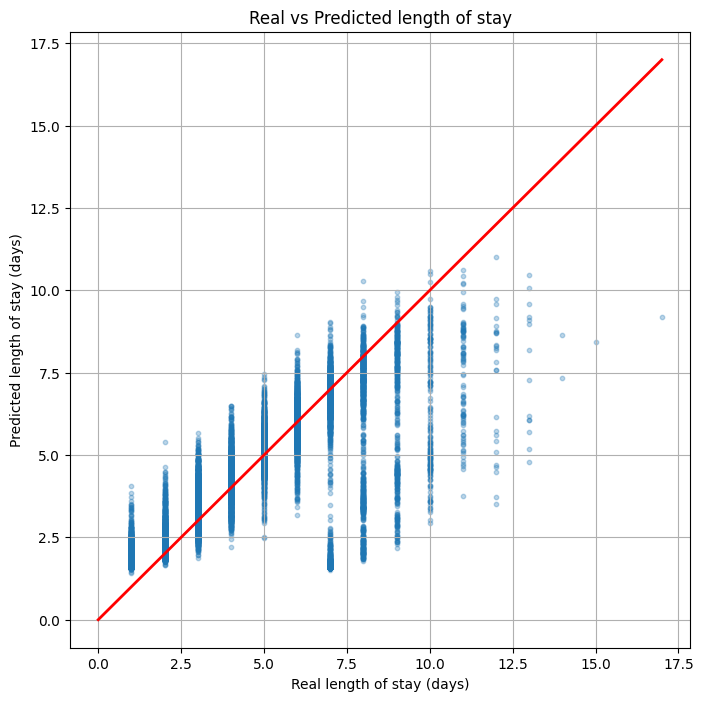

In [20]:
# Plot of actual vs. predicted LOS

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8)) #create the blank canvas

#create the scatter plot
plt.scatter(comparison_table['real_los'], comparison_table['predicted_los'],
            alpha=0.3, s=10) #transparency and size of each point

# Reference line (perfect prediction line)
plt.plot([0, comparison_table['real_los'].max()],
         [0, comparison_table['real_los'].max()],
         color='red', linewidth=2)

plt.xlabel("Real length of stay (days)")
plt.ylabel("Predicted length of stay (days)")
plt.title("Real vs Predicted length of stay")
plt.grid(True)

plt.show()


## Interpretation of actual vs prdicted LOS plot

The scatter plot compares the real length of stay of a patient with the model's predictions for the test set. The diagonal line represents perfect predition (Where PLOS = RLOS). The model follows the following behavior:

- #### Strong overall predictive trend:
  - As we can observe from the plot, most points align with the diagonal. This indicates that the model learned a meaningful relationship between patient features and LOS.
 
- #### Why the appearance of vertical lines. 
  - The vertical lines in the actual vs. predicted scatter plot occur because the actual length of stay (LOS) is recorded as an integer value (1, 2, 3, …), so all patients with the same LOS share the same X-coordinate. In contrast, the model’s predicted LOS is continuous, producing decimal values that spread vertically above each integer LOS value. As a result, the plot displays distinct vertical bands with gaps in between, which is completely normal given the discrete nature of the actual LOS and the continuous nature of the predictions.


